# Generative Medical Image Segmentation

In [266]:
import numpy as np
import pandas as pd
import os

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO
from pyro.optim import Adam

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro

from sklearn.model_selection import train_test_split

# Remove grids
sns.set_style("dark")
plt.style.use("dark_background")

In [267]:
# --- LOAD DATA ---
data_path = "data/" # Path to the data folder

# Define image paths
data = []

for dir_ in os.listdir(data_path):
    dir_path = os.path.join(data_path, dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"This is not an image folder: {dir_path}")


This is not an image folder: data/data.csv
This is not an image folder: data/README.md


In [268]:
# --- Create image and mask paths ---
df = pd.DataFrame(data, columns=["dir_name", "image_path"])

df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

imgs = sorted(df_imgs["image_path"].values, key = lambda x: int(x.split("_")[-1].split(".")[0]))
masks = sorted(df_masks["image_path"].values, key = lambda x: int(x.split("_")[-2]))

# --- Create final dataframe ---
df_final = pd.DataFrame()
df_final["image_path"] = imgs
df_final["mask_path"] = masks

# Create new column for diagnosis
def diagnosis(mask_path):
    """
    Function to determine the diagnosis based on the mask.
    If the mask is empty (all zeros), the diagnosis is 0.
    If the mask contains any non-zero values, the diagnosis is 1.
    """
    
    if np.max(cv2.imread(mask_path)) == 0:
        return 0
    else:
        return 1
    
df_final["diagnosis"] = df_final["mask_path"].apply(diagnosis)

In [279]:
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision.transforms as transforms
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0

In [280]:
# --- Define Dataset ---
class MRIDataset(Dataset):
    def __init__(self, df, img_transform=None, mask_transform=None):
        self.df = df
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        mask_path = self.df.iloc[idx]["mask_path"]

        # Read images with cv2
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.IMREAD_GRAYSCALE)

        # Convert numpy arrays to PIL images
        image = Image.fromarray(image)
        mask = Image.fromarray(mask).convert("L")

        if self.img_transform:
            image = self.img_transform(image)
            mask = self.mask_transform(mask)

        return image, mask

# Define the transformation
img_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


### Split Data into Training, Test Sets

In [281]:
# Split the data into training and validation sets
train_df, test_df = train_test_split(df_final, test_size=0.1, random_state=42, stratify=df_final["diagnosis"])

# Create datasets
train_dataset = MRIDataset(train_df, img_transform=img_transforms, mask_transform=mask_transforms)
test_dataset = MRIDataset(test_df, img_transform=img_transforms, mask_transform=mask_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 3536
Number of test samples: 393


### Vizualize MRI images and Masks

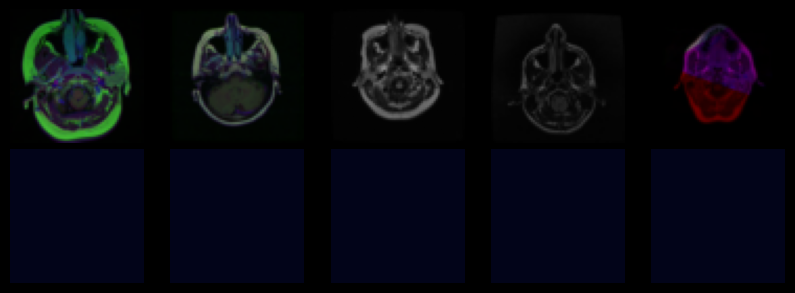

In [282]:
# --- Visualize some images and masks ---
def visualize_data(loader, num_images=5):
    images, masks = next(iter(loader))
    images = images.numpy()
    masks = masks.numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(10, 20))
    for i in range(num_images):
        axes[0, i].imshow(images[i].transpose(1, 2, 0))
        axes[0, i].axis("off")
        axes[1, i].imshow(masks[i].transpose(1, 2, 0))
        axes[1, i].axis("off")
    plt.subplots_adjust(hspace=-0.9)
    plt.show()

visualize_data(train_loader)

In [283]:
# --- Define Encoder ---
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim = IMG_SIZE*IMG_SIZE*3):
        self.input_dim = input_dim
        
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        x = x.reshape(-1, self.input_dim)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale
    
# --- Define Decoder ---
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super().__init__()
        
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc22 = nn.Linear(hidden_dim, output_dim)

        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        out = torch.sigmoid(self.fc22(hidden))
        return out

In [284]:
# --- Define VAE ---
class VAE(nn.Module):
    def __init__(self, z_dim=64, hidden_dim=248, input_dim=IMG_SIZE*IMG_SIZE*3):
        self.input_dim = input_dim
        self.output_dim = IMG_SIZE*IMG_SIZE
        super().__init__()

        # Define the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, self.input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, self.output_dim)
        self.z_dim = z_dim

    # Define the model p(x|z)p(z)
    def model(self, x, y):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):

            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=device)

            # sample from prior
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode the latent code z
            out = self.decoder.forward(z)
            
            # sample from the decoder p(x|z)
            pyro.sample("obs", dist.Bernoulli(out, validate_args=False).to_event(1), obs=y.reshape(-1, self.output_dim),)
            return out

    # Define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, y):
        # use the encoder to get the parameters used to define q(z|x)
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):

            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)

            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [285]:
def train(svi, train_loader):
    # initialize loss accumulator
    epoch_loss = 0.

    for img, mask in train_loader:

        # move data to device
        img = img.to(device)
        mask = mask.to(device)
    
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(img, mask)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train



def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for img, mask in test_loader:
        # move data to device
        img = img.to(device)
        mask = mask.to(device)
        
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(img, mask)  
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [288]:
# --- Training the VAE ---
NUM_EPOCHS = 50
TEST_FREQUENCY = 5
lr = 1e-3

def run_model():
    pyro.clear_param_store()  # clear everything before instantiation
    vae = VAE(z_dim=64, hidden_dim=248, input_dim=IMG_SIZE*IMG_SIZE*3)
    vae.to(device)

    # setup the optimizer
    optimizer = Adam({"lr": lr})
    svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())


    train_elbo = []
    test_elbo = []
    # training loop
    for epoch in range(NUM_EPOCHS):
        total_epoch_loss_train = train(svi, train_loader)
        train_elbo.append(-total_epoch_loss_train)
        print(f"[Epoch {epoch+1}]")
        print("Mean train loss: %.4f" %  total_epoch_loss_train)

        if epoch % TEST_FREQUENCY == 0:
            # report test diagnostics
            total_epoch_loss_test = evaluate(svi, test_loader)
            test_elbo.append(-total_epoch_loss_test)
            print("Mean test loss: %.4f" % total_epoch_loss_test)
        print("")
    return vae


vae = run_model()

[Epoch 1]
Mean train loss: 487.1354
Mean test loss: 178.0979

[Epoch 2]
Mean train loss: 181.2429
[Epoch 3]
Mean train loss: 172.5522
[Epoch 4]
Mean train loss: 168.8121
[Epoch 5]
Mean train loss: 164.1335
[Epoch 6]
Mean train loss: 162.3570
Mean test loss: 159.4453

[Epoch 7]
Mean train loss: 159.7763
[Epoch 8]
Mean train loss: 155.9235
[Epoch 9]
Mean train loss: 154.1028
[Epoch 10]
Mean train loss: 149.4333
[Epoch 11]
Mean train loss: 148.2519
Mean test loss: 138.1993

[Epoch 12]
Mean train loss: 146.0621
[Epoch 13]
Mean train loss: 141.2624
[Epoch 14]
Mean train loss: 138.0751
[Epoch 15]
Mean train loss: 134.2764
[Epoch 16]
Mean train loss: 130.2414
Mean test loss: 129.2602

[Epoch 17]
Mean train loss: 123.7948
[Epoch 18]
Mean train loss: 118.6344
[Epoch 19]
Mean train loss: 115.1815
[Epoch 20]
Mean train loss: 110.8514
[Epoch 21]
Mean train loss: 107.6778
Mean test loss: 103.7399

[Epoch 22]
Mean train loss: 104.5208
[Epoch 23]
Mean train loss: 102.3435
[Epoch 24]
Mean train loss: 

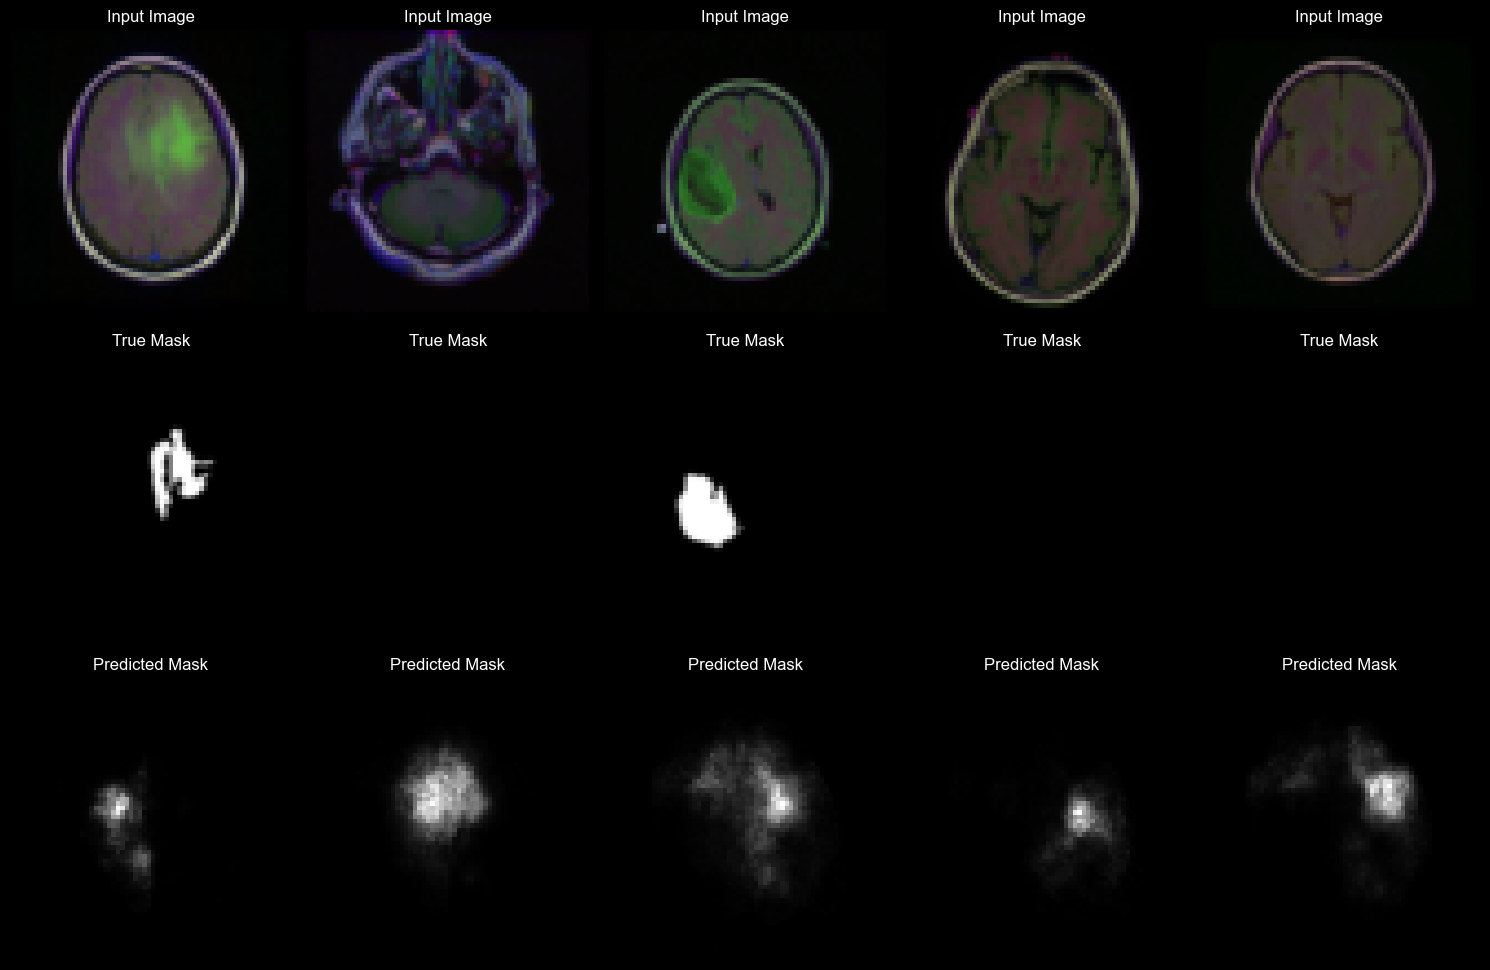

In [289]:
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images, true_masks = next(iter(loader))
    images = images.to(device)
    true_masks = true_masks.to(device)
    with torch.no_grad():
        # Get model predictions and reshape to the mask dimensions
        pred = model.model(images, true_masks)
    # Reshape predictions to match the true mask shape
    pred = pred.reshape(true_masks.size()).cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    images = images.cpu().numpy()
    
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))
    for i in range(num_images):
         # Show input image
         axes[0, i].imshow(images[i].transpose(1, 2, 0))
         axes[0, i].set_title("Input Image")
         axes[0, i].axis("off")
         # Show true mask (using grayscale for clarity)
         axes[1, i].imshow(true_masks[i].transpose(1, 2, 0), cmap='gray')
         axes[1, i].set_title("True Mask")
         axes[1, i].axis("off")
         # Show predicted mask (using grayscale for clarity)
         axes[2, i].imshow(pred[i].transpose(1, 2, 0), cmap='gray')
         axes[2, i].set_title("Predicted Mask")
         axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()


visualize_predictions(vae, test_loader)